<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/08.%20Nou%20Barris/Forecasting_(Indicador_85).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**


1. [Importar bibliotecas](#Importar-bibliotecas)
2. [Carga de datos](#Carga-de-datos)
3. [Preparacion de los datos](#Preparacion-de-los-datos)
4. [Analisis por grupo de indicadores (m² por habitante de Zonas Verdes)](#Analisis-por-grupo-de-indicadores-(zonas-verdes))
  - [Preparacion de datos](#Preparacion-de-datos)
  - [Analisis Exploratorio](#Analisis-Exploratorio)
  - [Modelo VAR](#Modelo-VAR)
  - [Modelo VARMAX](#Modelo-VARMAX)
5. [Conclusiones](#Conclusiones)



**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

##Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [2]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [3]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (m² por habitante de Zonas Verdes)

### Preparacion de datos

In [4]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','m² por habitante']]

In [5]:
df_cont = df_sel.dropna()

In [6]:
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7008 entries, 0 to 7007
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Any                   7008 non-null   int64  
 1   Trimestre             7008 non-null   int64  
 2   Mes                   7008 non-null   int64  
 3   Codi_Districte        7008 non-null   int64  
 4   Nom_Districte         7008 non-null   object 
 5   Codi_Barri            7008 non-null   int64  
 6   Nom_Barri             7008 non-null   object 
 7   Compraventa_Unitario  7008 non-null   float64
 8   m² por habitante      7008 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 547.5+ KB


In [7]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_cont['Fecha'] = pd.to_datetime(df_cont['Any'].astype(str) + '-' + df_cont['Mes'].astype(str) + '-1')

In [8]:
# Modificamos el indice del dataset por la fecha
df_contI = df_cont.set_index('Fecha')

In [9]:
df_contI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,m² por habitante
Fecha,,,,,,,,,
2014-01-01,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,6.2
2014-02-01,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,6.2
2014-03-01,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,6.2
2014-04-01,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,6.2
2014-05-01,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,6.2


### Analisis Exploratorio

Filtramos los datos por el distrito de Nou Barris -> Codi_Districte = 8

In [10]:
df_contFiltrado = df_contI[df_contI['Codi_Districte'] == 8]

In [11]:
# Agrupamos los datos
df =df_contFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [12]:
df.head()

,Compraventa_Unitario,m² por habitante
Fecha,,
2014-01-01,1511.900000,6.9
2014-02-01,1511.900000,6.9
2014-03-01,1511.900000,6.9
2014-04-01,1633.069231,6.9
2014-05-01,1633.069231,6.9


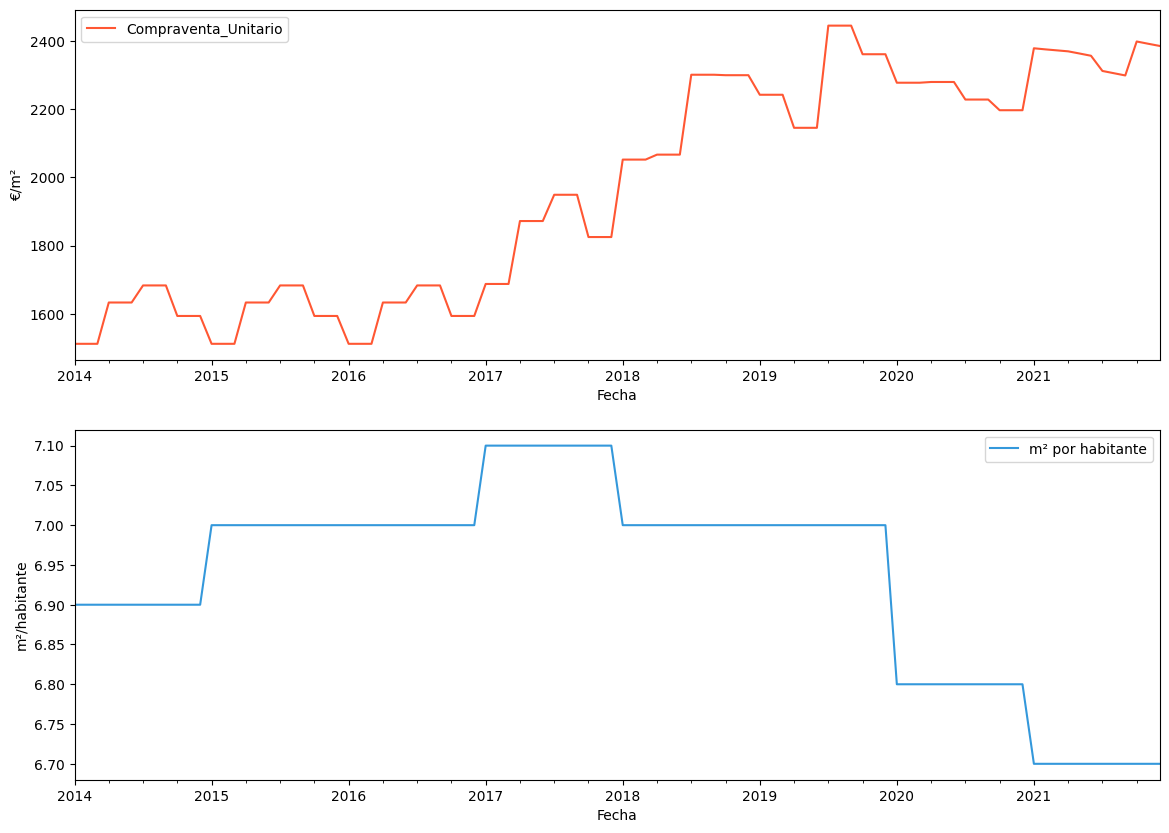

In [14]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²','m²/habitante']
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Cada una de las series tiene patrones de tendencia muy diferentes entre si

In [15]:
corr=df.corr()
corr

,Compraventa_Unitario,m² por habitante
Compraventa_Unitario,1.000000,-0.475285
m² por habitante,-0.475285,1.000000


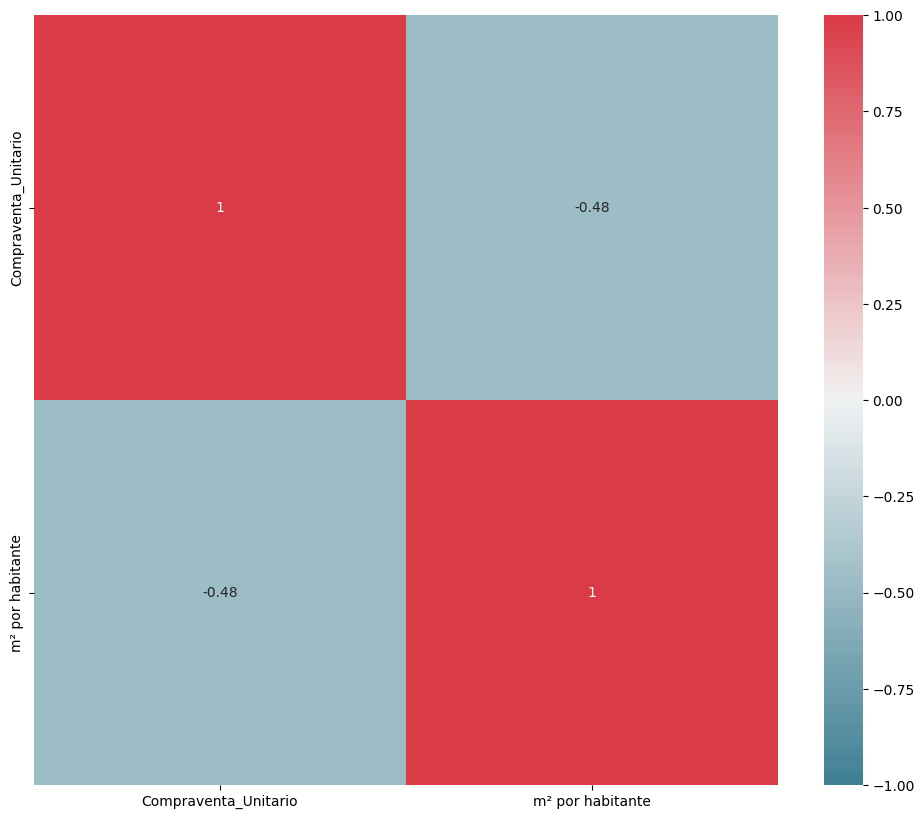

In [16]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

La correlación entre "Compraventa_Unitario" y "m² por habitante" es de -0.475285. Esto sugiere una correlación negativa moderada entre estas dos variables. Cuando una variable aumenta, la otra tiende a disminuir, y viceversa, pero no de manera perfectamente lineal.

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola srie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de usus propios valores pasados y de los valores pasados de las otras series temporales.
**Es util cuando las diferentes series temporales estan interrelacionadas y se influyen mutuamente.**




##### Dividir los datos en conjunto de Entrenamiento y Prueba


El modelo VAR se ajustará al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.



---



In [17]:
fecha_division = '2021-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)


(84, 2) (12, 2)


##### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [18]:
import statsmodels.tsa.stattools as sts

In [19]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.678363
Serie de tiempo m² por habitante
p-value: 0.759099


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [20]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,m² por habitante
Fecha,,
2014-02-01,0.000000,0.0
2014-03-01,0.000000,0.0
2014-04-01,121.169231,0.0
2014-05-01,0.000000,0.0
2014-06-01,0.000000,0.0


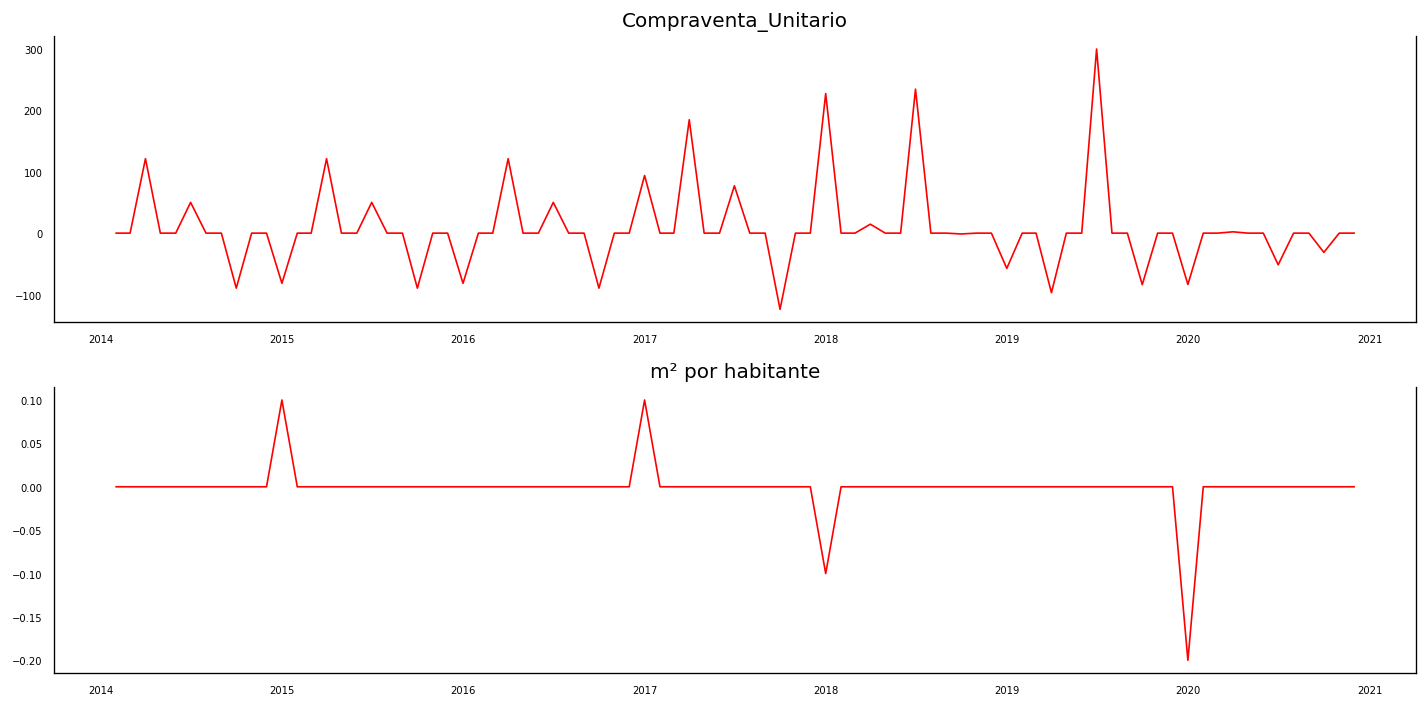

In [22]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [23]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.466546
Serie de tiempo transformada Variable m² por habitante
p-value: 0.000000


In [24]:
X_train_transformed=X_train_transformed.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,m² por habitante
Fecha,,
2014-03-01,0.000000,0.0
2014-04-01,121.169231,0.0
2014-05-01,-121.169231,0.0
2014-06-01,0.000000,0.0
2014-07-01,50.076923,0.0


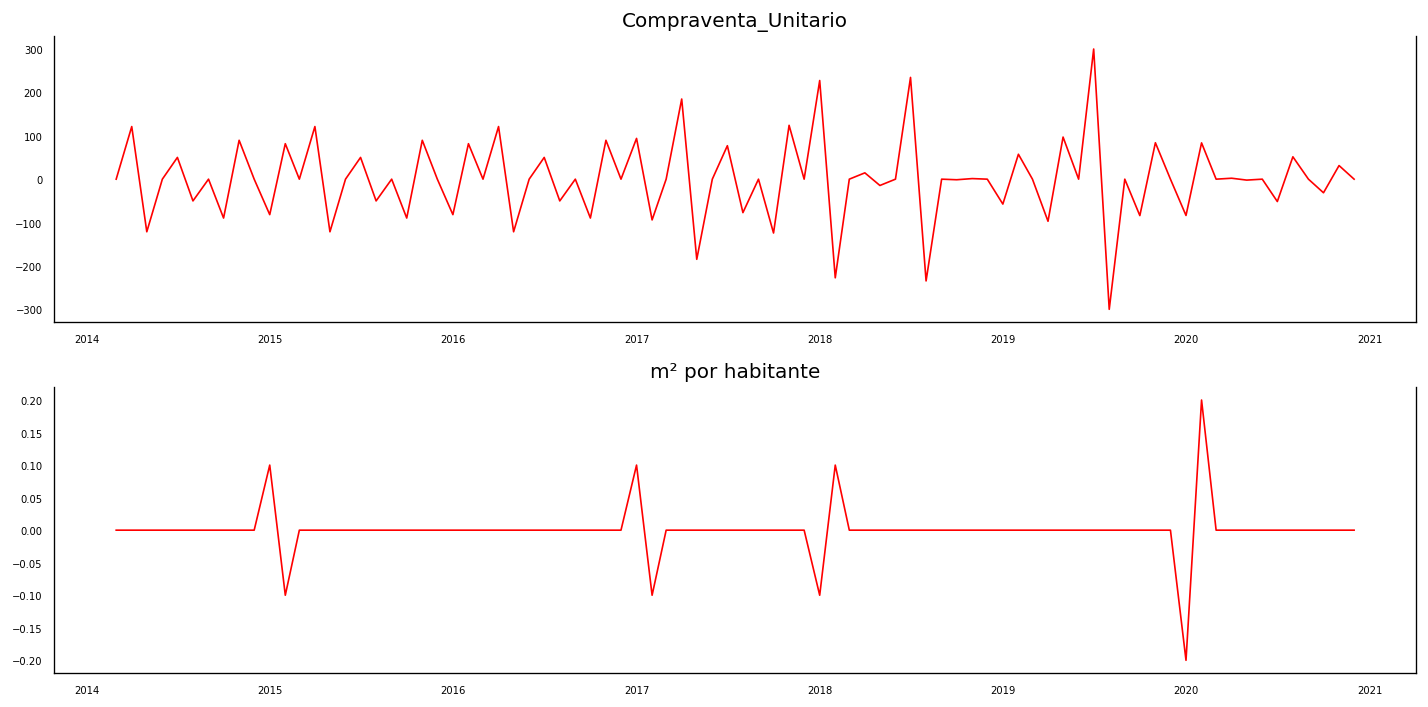

In [25]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [26]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable m² por habitante
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 2 ordenes de diferenciación se obtienen series estacionarias.

In [27]:
from statsmodels.tsa.api import VAR

In [28]:
model = VAR(X_train_transformed)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Seleccionando el orden del modelo

In [29]:
modelsel=model.select_order(12)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,2.893,2.957,18.05,2.919
1,2.460,2.653*,11.71,2.537
2,2.375,2.696,10.75,2.502
3,2.296,2.746,9.949,2.475*
4,2.308,2.886,10.08,2.537
5,2.264,2.970,9.670,2.545
6,2.278,3.113,9.839,2.609
7,2.327,3.290,10.38,2.710
8,2.328,3.420,10.47,2.762
9,2.418,3.638,11.54,2.903


#### Ajustando el modelo

In [33]:
res = model.fit(maxlags=12, ic='aic')
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 11, May, 2024
Time:                     08:30:52
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    3.49249
Nobs:                     71.0000    HQIC:                   2.60950
Log likelihood:          -227.431    FPE:                    7.96411
AIC:                      2.02653    Det(Omega_mle):         4.54358
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           -3.314108         7.962647           -0.416           0.677
L1.Compraventa_Unitario         -0.962206         0.112110           -8.583           0.000
L

En la matriz de correlación de los residuos, observamos que la correlación entre "Compraventa_Unitario" y "m² por habitante" es bastante baja, con un valor de 0.113571. Esto sugiere que los residuos de estas dos variables apenas están correlacionados entre sí después de ajustar el modelo.

In [34]:
X_train.columns

Index(['Compraventa_Unitario', 'm² por habitante'], dtype='object')

###### Causalidad de Granger

In [35]:
grangercaus=res.test_causality(['m² por habitante'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.356,1.890,0.207,"(11, 96)"


In [36]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['m² por habitante'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.9443,1.890,0.502,"(11, 96)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede predecir la otra serie temporal

###### Matriz de causalidad de Granger


In [37]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=12
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,Compraventa_Unitario_x,m² por habitante_x
Compraventa_Unitario_y,1.0000,0.1664
m² por habitante_y,0.0097,1.0000


Con esta matriz queda claro que la serie temporal de Compraventa_Unitario no causa ni es causada por la otra serie temporal de ParadosReg

###### Diagnosis del modelo


###### Residuos

In [38]:
residuals=res.resid

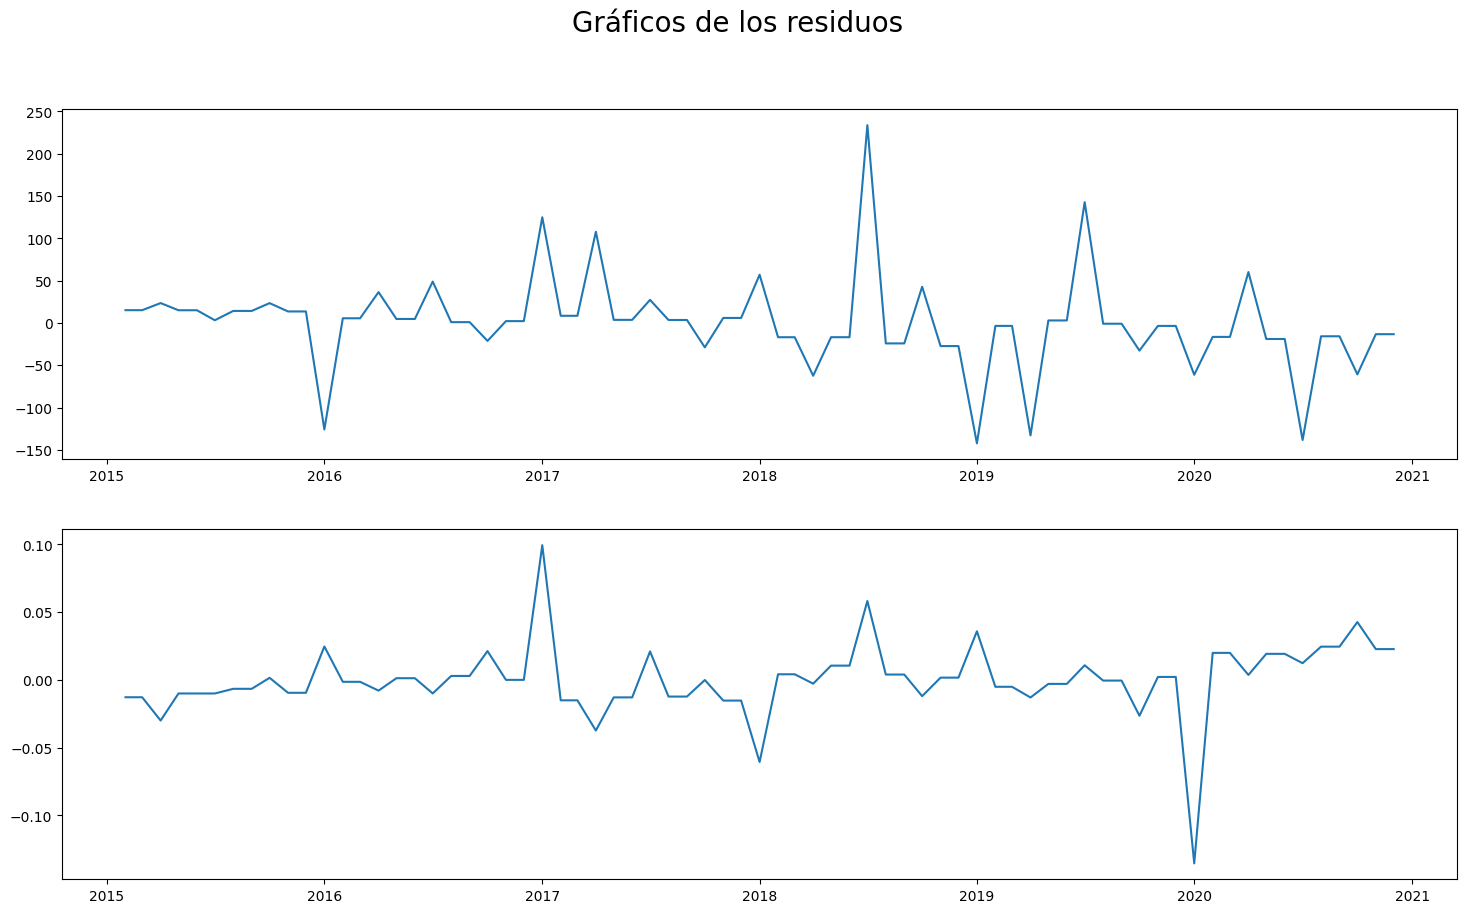

In [40]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [41]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[2.3673671849225693e-12, 2.4122113683742284e-11]

Todos los p-valores son < 0.1 por tanto se rechaza la hipótesis nula de que las 3 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.



###### ACF de los Residuos


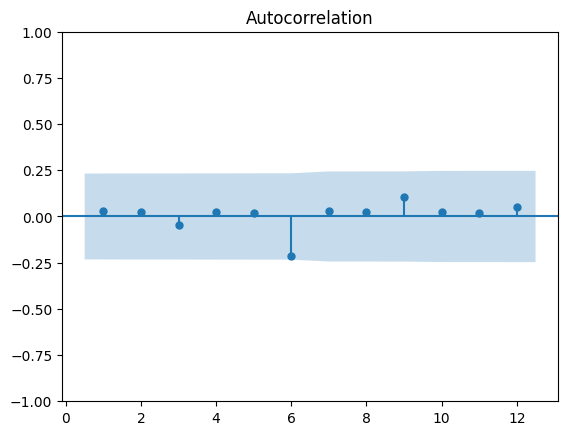

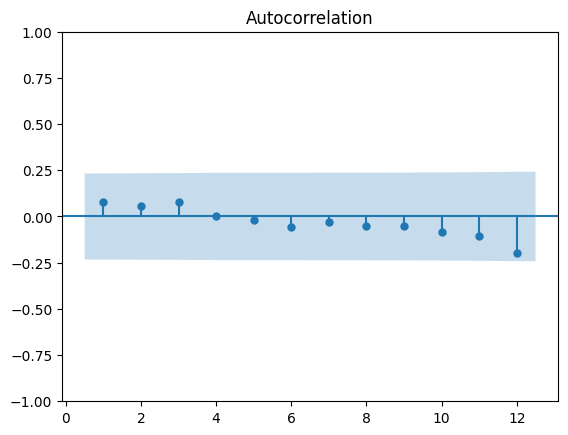

In [43]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Conclusión: Los residuos del modelo no presentan estructura de autocorrelación, son estacionarios según los resultados de la prueba de Dickey - Fuller aumentada y en los gráficos se puede comprobar esto visualmente, entonces puede concluirse que son ruido blanco como es deseable.



#### Valores predichos


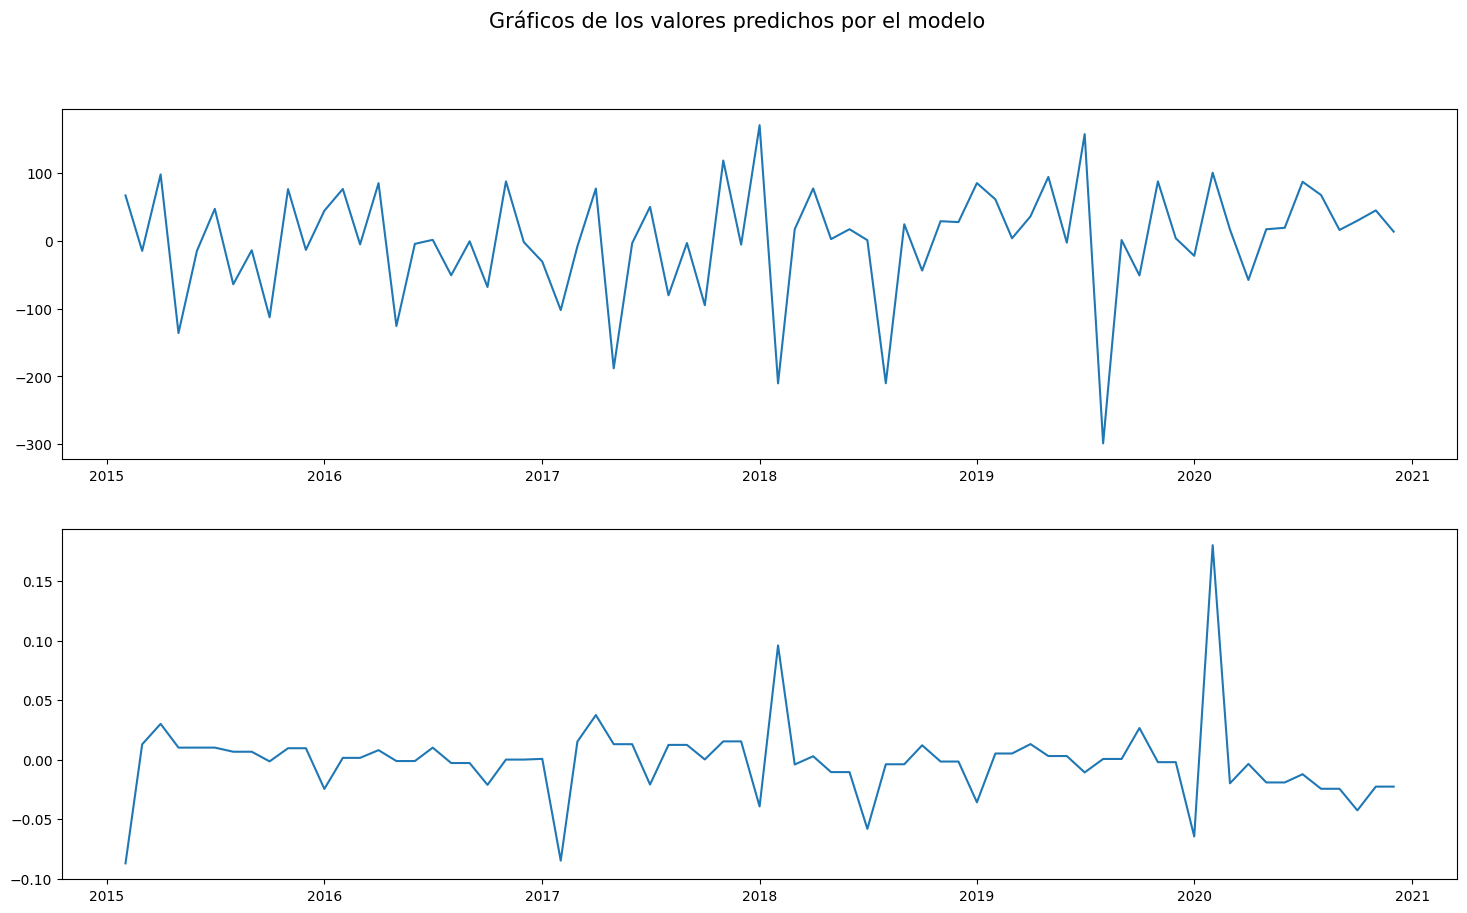

In [45]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.



In [46]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=12)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 11
Predicciones:


,Compraventa_Unitario_pred,m² por habitante_pred
Fecha,,
2021-01-01,-206.953896,0.064561
2021-02-01,186.212061,-0.062215
2021-03-01,-1.008476,-0.000001
2021-04-01,43.831122,0.004692
2021-05-01,-43.399258,-0.004184
2021-06-01,-1.211626,0.000041
2021-07-01,-6.745152,0.040257
2021-08-01,4.281523,-0.034533
2021-09-01,-1.656286,0.000509


<Figure size 1200x1000 with 0 Axes>

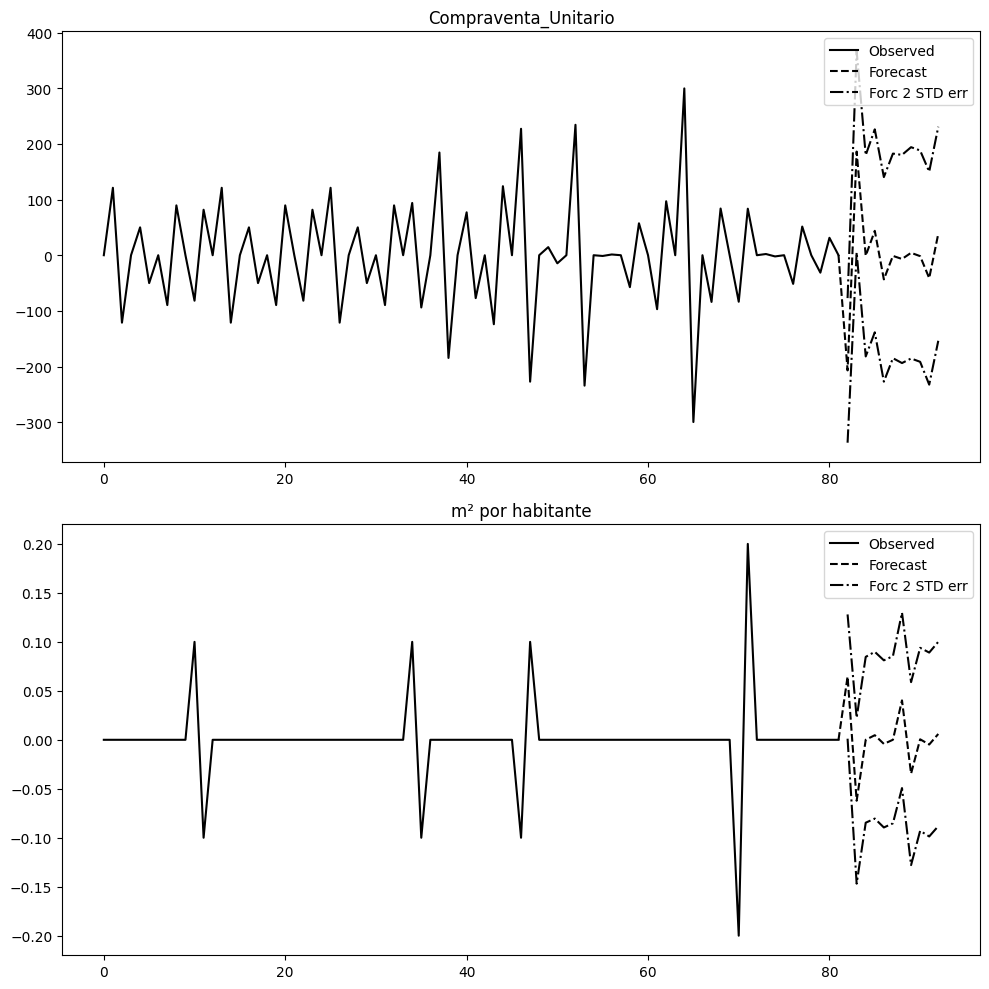

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)



In [48]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [49]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=True)
output

,Compraventa_Unitario,m² por habitante
Fecha,,
2021-01-01,1990.130719,6.864561
2021-02-01,1969.388885,6.866908
2021-03-01,1947.638574,6.869253
2021-04-01,1969.719385,6.876289
2021-05-01,1948.400939,6.879142
2021-06-01,1925.870866,6.882035
2021-07-01,1896.595642,6.925186
2021-08-01,1871.601941,6.933804
2021-09-01,1844.951953,6.942931


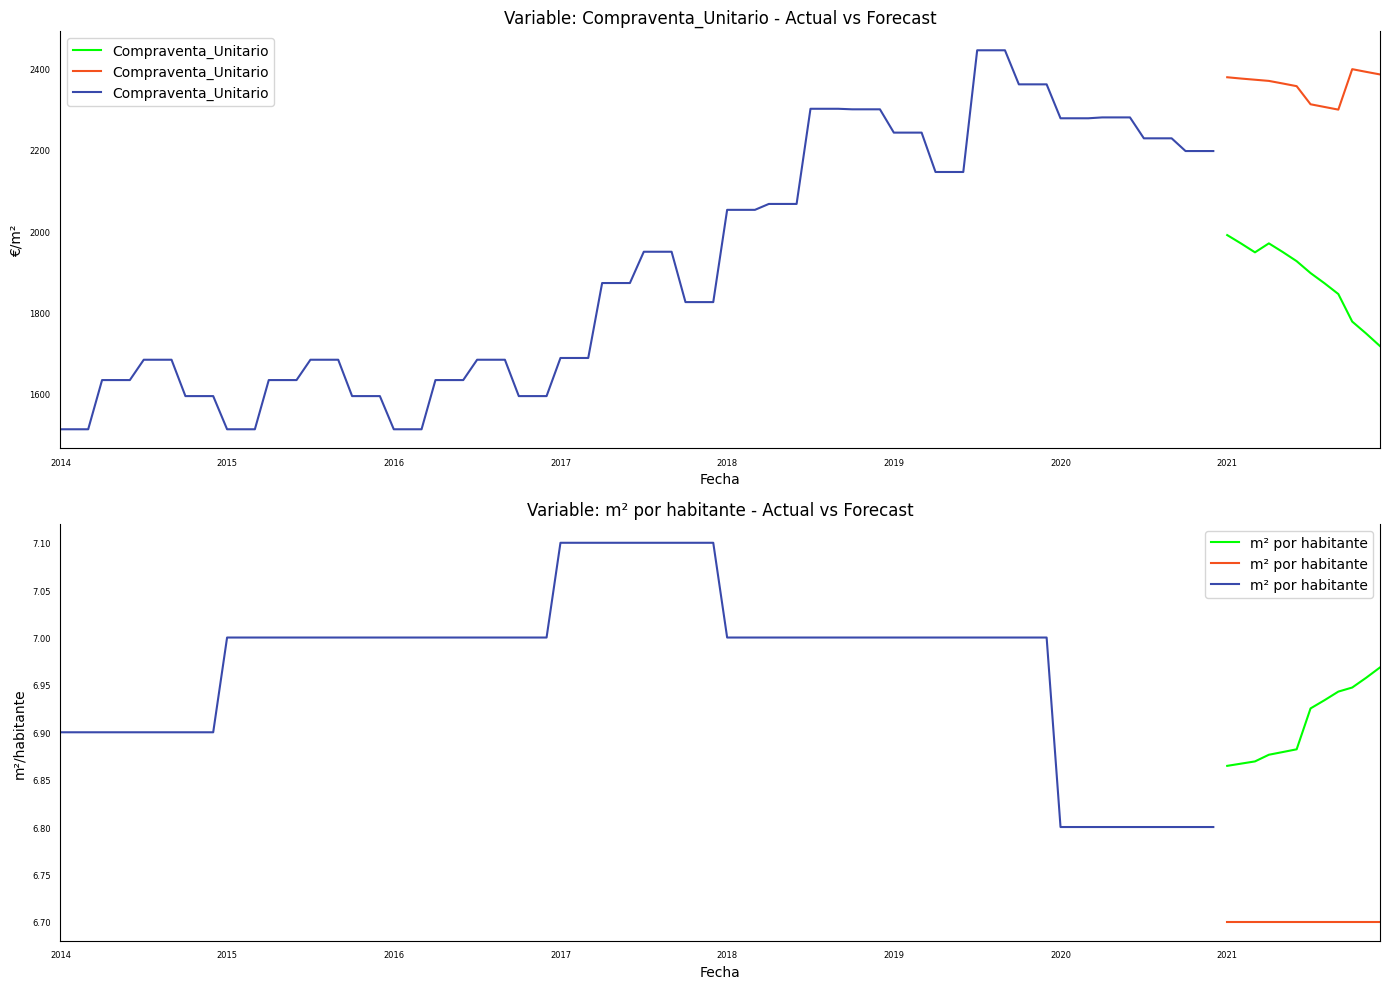

In [51]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²','m²/habitante']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [52]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [54]:
for i in ['Compraventa_Unitario','m² por habitante']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , output[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 235950.88470306096
MAE is : 475.4070514637515
RMSE is : 485.747758309867
MAPE is : 20.127561651490673
R2 is : -216.7480659137823

Evaluation metric for m² por habitante
Evaluation metric results:-
MSE is : 0.045313915491770544
MAE is : 0.2094395680817105
RMSE is : 0.21287065436966773
MAPE is : 3.1259637027120966
R2 is : -5.744221217183419e+28



Para "Compraventa_Unitario", todas las métricas de evaluación son muy altas, lo que indica un mal ajuste del modelo. El R cuadrado negativo indica que el modelo es inapropiado para explicar la variabilidad de los datos y puede que esté sobreajustado.

Para "m² por habitante", las métricas son más razonables en comparación, excepto por un valor extremadamente negativo de R cuadrado, lo que sugiere que el modelo no es adecuado para explicar la variabilidad de los datos. Esto podría ser debido a un sobreajuste o a un mal ajuste del modelo.

In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 237.8082455159166
Root mean squared error: 343.47556682897874


### Modelo VARMAX (Auto Arima)

El modelo VARMAX es una extension del modelo VAR que permite incorporar variebles exogenas, es decir, varibales externas que pueden afectar a las series temporales del sistema, es decir, que ademas de modelar la dependencia entre las variables del sistema, el VARMAX tambien puede capturar la influencia de variables externas sobre las series temporales.

In [56]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.8 MB/s eta 0:00:00


#### Dividir los datos en conjuntos de Entrenamiento Y Prueba

In [57]:
fecha_division = '2021-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)

(84, 2) (12, 2)


#### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [58]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.678363
Serie de tiempo m² por habitante
p-value: 0.759099


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [59]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,m² por habitante
Fecha,,
2014-02-01,0.000000,0.0
2014-03-01,0.000000,0.0
2014-04-01,121.169231,0.0
2014-05-01,0.000000,0.0
2014-06-01,0.000000,0.0


In [60]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.466546
Serie de tiempo transformada Variable m² por habitante
p-value: 0.000000


In [61]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,m² por habitante
Fecha,,
2014-03-01,0.000000,0.0
2014-04-01,121.169231,0.0
2014-05-01,-121.169231,0.0
2014-06-01,0.000000,0.0
2014-07-01,50.076923,0.0


In [62]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable m² por habitante
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 2 ordenes de diferenciación se obtienen series estacionarias.

####Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [63]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [64]:
cointegration_test(X_train_transformed[['Compraventa_Unitario','m² por habitante']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  60.99     > 12.3212   =>   True
m² por habitante >  26.33     > 4.1296    =>   True


Este resultado indica que ambas variables, "Compraventa_Unitario" y "m² por habitante", son estadísticamente significativas para explicar la variable dependiente en el modelo. Es decir, tienen un impacto significativo en el resultado que estamos tratando de predecir. Por lo tanto, estas variables son importantes para entender y modelar el fenómeno que estamos analizando.

#### Ajustando el modelo

#####Auto Arima

Aplicaremos autoarima, para determinar los valores de p, q y d

In [65]:
import pmdarima as pm

In [66]:

pq = []
for name in ['Compraventa_Unitario', 'm² por habitante']:
    print(f'Searching order of p and q for : {name}')
    # Ajusta un modelo ARIMA para cada columna
    stepwise_model = pm.auto_arima(X_train_transformed[name],
                                start_p=0, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True,
                                maxiter=1000)
    # Obtiene los parámetros óptimos de p y q del modelo
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    # Agrega los parámetros óptimos a la lista pq
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Compraventa_Unitario
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=983.746, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=962.440, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=959.229, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=953.560, Time=0.22 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=951.228, Time=0.45 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=953.213, Time=0.34 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0]          
Total fit time: 2.412 seconds
optimal order for:Compraventa_Unitario is: (4, 0, 0) 


Searching order of p and q for : m² por habitante
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-287.866, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : 

#####Seleccion del modelo

In [67]:
def inverse_diff(actual_df, pred_df, second_diff=False):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        if second_diff:
          df_res[str(col)] = (actual_df[col].iloc[-1]- actual_df[col].iloc[-2]) + df_res[str(col)].cumsum()

        df_res[str(col)] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [68]:
pq

[(4, 0, 0), (0, 0, 1)]

Para Compraventa Unitario (4, 0, 0):

- p = 4: Indica que se utiliza un componente autorregresivo (AR) de orden 4, lo que implica que el valor actual de la serie temporal depende de los cuatro valores anteriores.
- d = 0: Indica que no se ha aplicado ninguna diferenciación en la serie temporal para hacerla estacionaria.
- q = 0: Indica que no se utiliza ningún componente de media móvil (MA) en este modelo.

Para m² de zona verde por habitante (0, 0, 1):

- p = 0: Indica que no hay componente autorregresivo estacional.
- d = 0: Indica que no se ha aplicado ninguna diferenciación estacional.
- q = 1: Indica que se utiliza un componente de media móvil estacional (SMA) de orden 1.

In [69]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [70]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE Compraventa_Unitario','RMSE m² por habitante'])
print('Grid Search Started')
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(X_train_transformed[['Compraventa_Unitario', 'm² por habitante']], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 12)
        inv_res = inverse_diff(df[['Compraventa_Unitario', 'm² por habitante']] , result, True)
        Comprarmse = np.sqrt(metrics.mean_squared_error(X_test['Compraventa_Unitario'], inv_res.Compraventa_Unitario))
        Pmrmse = np.sqrt(metrics.mean_squared_error(X_test['m² por habitante'], inv_res['m² por habitante']))
        #df_results_moni = df_results_moni.append({'p': i[0], 'q': i[2], 'RMSE Compraventa_Unitario':Comprarmse,'RMSE ParadosReg':Paradosrmse }, ignore_index=False)
        df_results_moni.loc[len(df_results_moni)] = [i[0], i[2], Comprarmse, Pmrmse]


Grid Search Started
 Running for (4, 0, 0)
 Running for (0, 0, 1)


In [71]:
df_results_moni.sort_values(by = ['RMSE Compraventa_Unitario','RMSE m² por habitante'] )

,p,q,RMSE Compraventa_Unitario,RMSE m² por habitante
1,0.0,1.0,44.770879,0.001238
0,4.0,0.0,72.769965,0.003295


#### Pronósticos a futuro


In [72]:
model = VARMAX(X_train_transformed[['Compraventa_Unitario','m² por habitante']], order=(0,2)).fit(disp=False)
result = model.forecast(steps = 12)

In [73]:
result

,Compraventa_Unitario,m² por habitante
2021-01-01,-8.936328,-0.013940
2021-02-01,-1.851008,-0.004618
2021-03-01,-0.000786,-0.000339
2021-04-01,-0.000786,-0.000339
2021-05-01,-0.000786,-0.000339
2021-06-01,-0.000786,-0.000339
2021-07-01,-0.000786,-0.000339
2021-08-01,-0.000786,-0.000339
2021-09-01,-0.000786,-0.000339
2021-10-01,-0.000786,-0.000339


#### Invertiendo la transformacion de los pronosticos a la escala original

In [74]:
res = inverse_diff(df[['Compraventa_Unitario', 'm² por habitante']],result,True)

In [75]:
res

,Compraventa_Unitario,m² por habitante
2021-01-01,2370.429350,6.686060
2021-02-01,2353.263882,6.667502
2021-03-01,2336.097629,6.648606
2021-04-01,2318.930590,6.629370
2021-05-01,2301.762765,6.609796
2021-06-01,2284.594154,6.589882
2021-07-01,2267.424758,6.569630
2021-08-01,2250.254576,6.549039
2021-09-01,2233.083609,6.528109
2021-10-01,2215.911855,6.506840


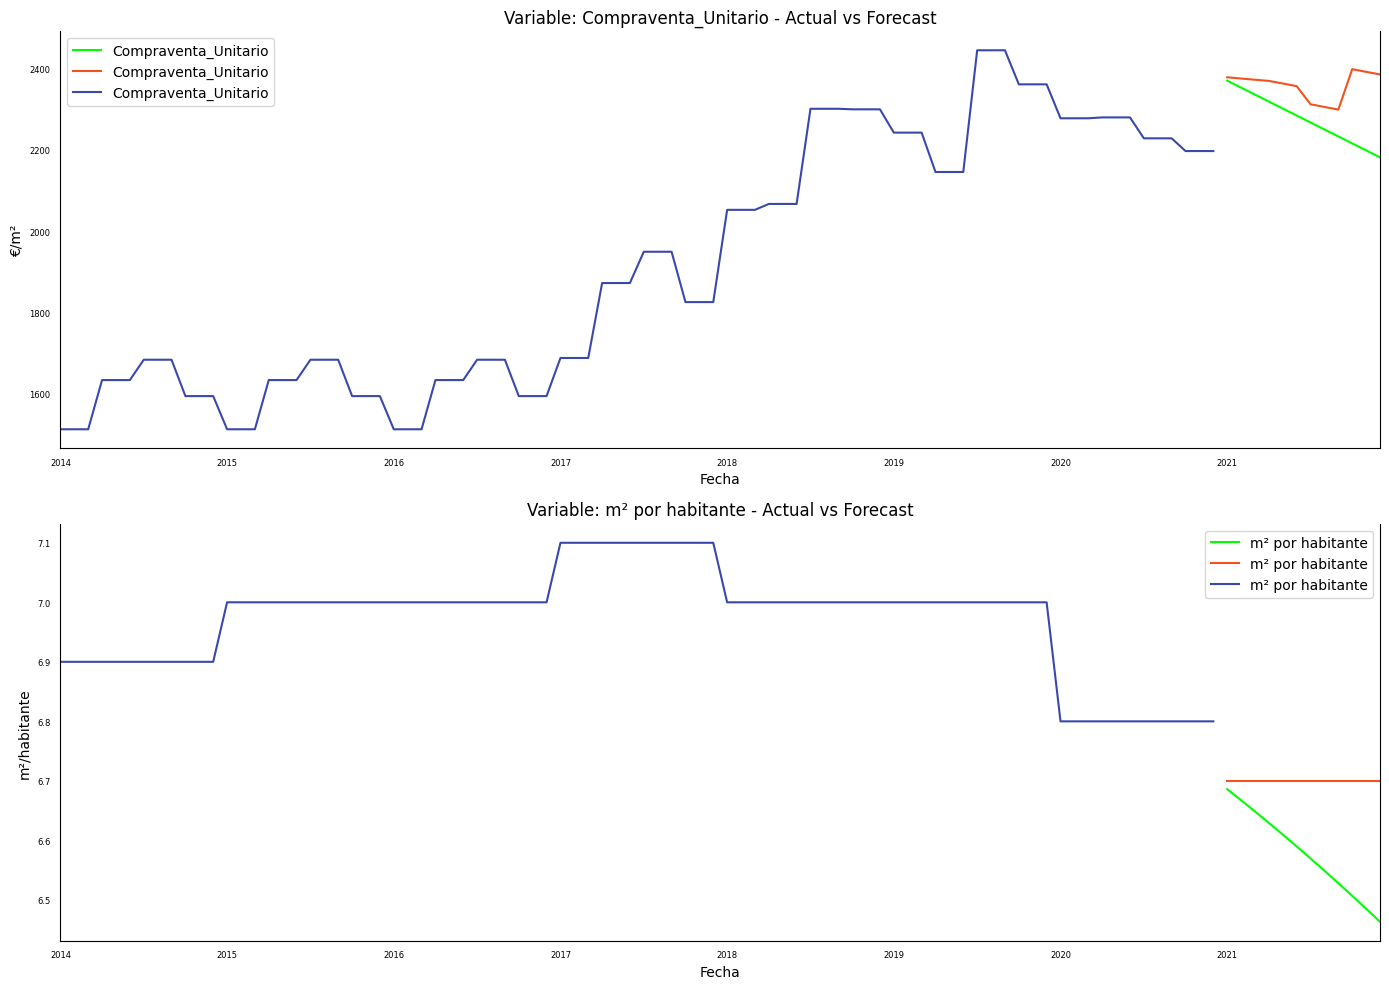

In [76]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²','m²/habitante']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    res[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo

In [77]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [78]:
for i in ['Compraventa_Unitario','m² por habitante']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , res[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 11288.388871595547
MAE is : 83.22768343533683
RMSE is : 106.24682993668821
MAPE is : 3.511122425772579
R2 is : -9.417527559457827

Evaluation metric for m² por habitante
Evaluation metric results:-
MSE is : 0.01982882626356836
MAE is : 0.12222089095395638
RMSE is : 0.1408148652080751
MAPE is : 1.8241924022978564
R2 is : -2.513602351483371e+28



En ambos casos, parece haber un ajuste insatisfactorio del modelo, especialmente evidenciado por valores negativos en R2, lo que sugiere que el modelo no explica la variabilidad de los datos. Además, los errores absolutos y cuadráticos son bastante altos, lo que indica que el modelo puede no estar capturando adecuadamente la estructura subyacente de los datos.

In [79]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, res))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, res)))

Mean absolute error: 41.67495216314539
Root mean squared error: 75.12791991138118


##Conclusiones

Como conclusiones de realizar un analisis de datos forecasting a los datos de distrito de **Nou Barris** de Barcelona entre las dos series temporales de Compraventa_unitario y m² por habitante de zonas verdes, tenemos que:

- Se ha comprobado que las variables tienen alta correlacion inversa.
- Se ha comprobado que la dos series de datos temporales tienen estacionalidad a partir del segundo orden de diferenciacion, lo que las hace aptas para aplicar los dos modelos VAR y VARMAX .
- En el modelo VAR se ha comprobado la causalidad de Granger, y esta ha salido negativa, lo que quiere decir que ninguna serie temporal puede causar las demas series temporales. Esto en un principio nos advierte que este modelo sera más aconsejable que el modelo VARMAX
- El test de cointegracion en el modelo VARMAX nos ha dado positivo, lo que significa que las series estan relacionadas en el tiempo y que serie estos datos pueden ser aptos para este modelo

Como hemos visto, los modelos obtenidos no se ajustan a los datos de test, dado que las series temporales no cumplen varias limitaciones de los modelos a aplicar. Fruto de ellos son modelos con limitaciones en la capacidad predictiva, y modelado incorrecto de la relacion entre ellas.  

